Plot saved to /Users/Frank/Downloads/DBA-fitting/all_replicas_fitting_plot_with_outliers.png


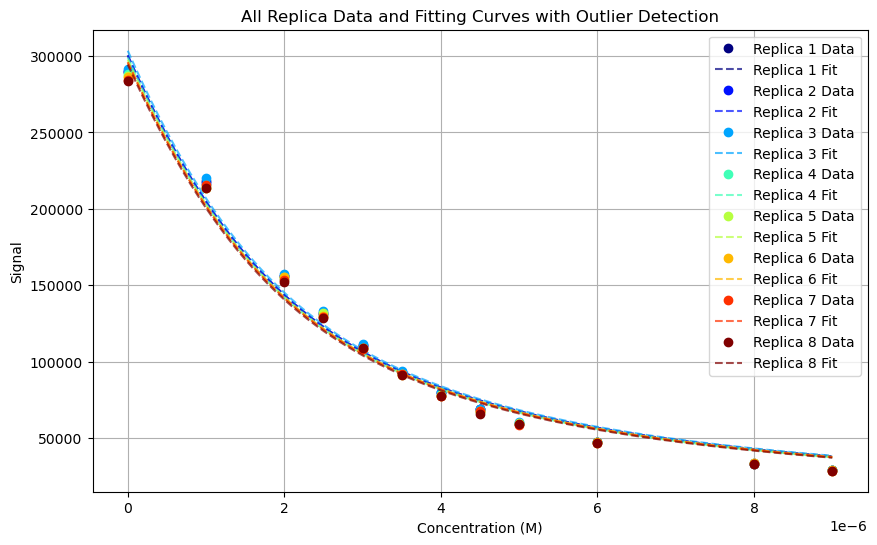


Final Retained Replicas:
Replica 1: RMSE = 8769.79, R² = 0.987, Kd = 9.00e+05
Replica 2: RMSE = 8464.18, R² = 0.987, Kd = 9.02e+05
Replica 3: RMSE = 9017.60, R² = 0.986, Kd = 9.00e+05
Replica 4: RMSE = 8228.98, R² = 0.988, Kd = 9.13e+05
Replica 5: RMSE = 8554.98, R² = 0.987, Kd = 8.99e+05
Replica 6: RMSE = 8431.89, R² = 0.987, Kd = 8.98e+05
Replica 7: RMSE = 8748.93, R² = 0.986, Kd = 8.99e+05
Replica 8: RMSE = 8440.99, R² = 0.987, Kd = 9.04e+05
Plot saved to /Users/Frank/Downloads/DBA-fitting/averaged_fitting_plot.png


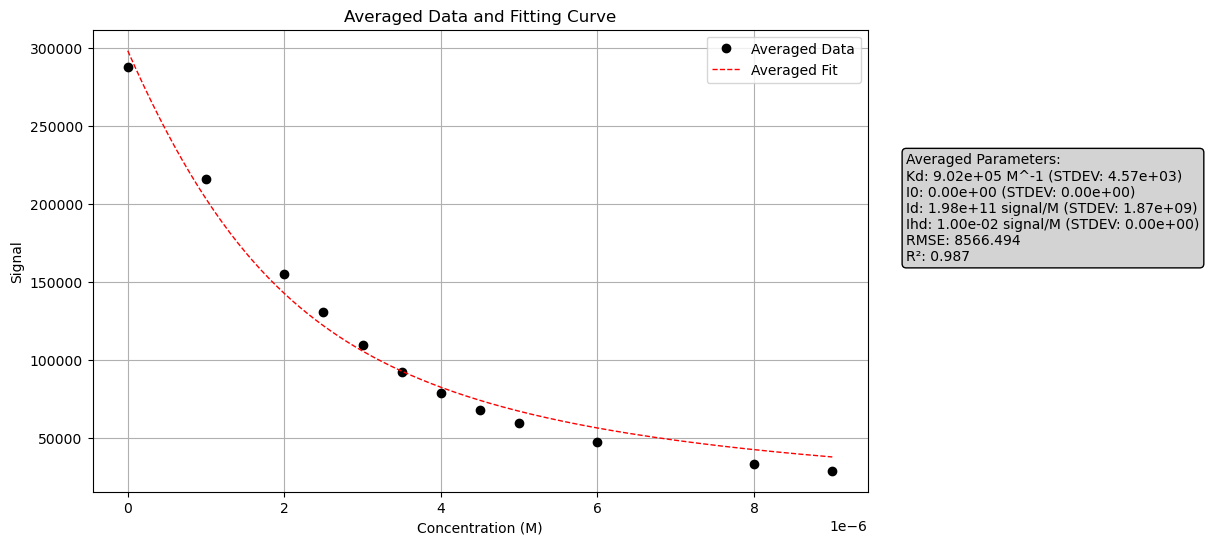

Averaged data and fitting results saved to /Users/Frank/Downloads/DBA-fitting/averaged_fit_results.txt


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from datetime import datetime

# User-defined variables for threshold adjustments
results_dir = '/Users/Frank/Downloads/DBA-fitting'  # Adjust this path as needed
outlier_relative_threshold = 0.25  # Relative threshold for outlier detection as a fraction of the median
rmse_threshold_factor = 3  # Number of standard deviations for RMSE filtering
kd_threshold_factor = 3  # Number of standard deviations for Kd filtering

#################################################################################################################
# Do NOT change code after this line
#################################################################################################################

# Function to compute Signal based on the DBA model and given parameters
def compute_signal(params, h0_values, d0, kd):
    I0, Kd, Id, Ihd = params
    Signal_values = []
    for h0 in h0_values:
        delta = h0 - d0
        a = Kd
        b = Kd * delta + 1
        c = -d0
        discriminant = b**2 - 4 * a * c

        if discriminant < 0:
            Signal_values.append(np.nan)
            continue

        sqrt_discriminant = np.sqrt(discriminant)
        d1 = (-b + sqrt_discriminant) / (2 * a)
        d2 = (-b - sqrt_discriminant) / (2 * a)
        d = d1 if d1 >= 0 else d2 if d2 >= 0 else np.nan
        if np.isnan(d):
            Signal_values.append(np.nan)
            continue

        h = d + delta
        hd = Kd * h * d
        Signal = I0 + Id * d + Ihd * hd
        Signal_values.append(Signal)
    return np.array(Signal_values)

# Function to save the plot as a PNG file
def save_plot(fig, filename, results_dir):
    plot_file = os.path.join(results_dir, filename)
    fig.savefig(plot_file, bbox_inches='tight')
    print(f"Plot saved to {plot_file}")

# Function to calculate RMSE and R² for model accuracy assessment
def calculate_fit_metrics(observed, computed):
    rmse = np.sqrt(np.nanmean((observed - computed) ** 2))
    ss_res = np.nansum((observed - computed) ** 2)
    ss_tot = np.nansum((observed - np.nanmean(observed)) ** 2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan
    return rmse, r_squared

# Function to detect outliers based on relative deviation from the cross-replica median at each data point
def detect_outliers_per_point(data, reference, relative_threshold):
    deviations = np.abs(data - reference)
    outlier_indices = np.where(deviations > relative_threshold * reference)[0]
    return outlier_indices

# Function to export averaged data and fitting results to a text file
def export_averaged_data(avg_concentrations, avg_signals, avg_fitting_curve_x, avg_fitting_curve_y, avg_params, stdev_params, rmse, r_squared, results_dir, input_values, retained_replicas_info):
    averaged_data_file = os.path.join(results_dir, "averaged_fit_results.txt")
    with open(averaged_data_file, 'w') as f:
        f.write("Input:\n")
        for key, value in input_values.items():
            f.write(f"{key}: {value}\n")
        f.write("\nRetained Replicas:\n")
        f.write("Replica\tKd (M^-1)\tI0\tId (signal/M)\tIhd (signal/M)\tRMSE\tR²\n")
        for replica_info in retained_replicas_info:
            original_index, params, fit_rmse, fit_r2 = replica_info
            f.write(f"{original_index}\t{params[1] * 1e6:.2e}\t{params[0]:.2e}\t{params[2] * 1e6:.2e}\t{params[3] * 1e6:.2e}\t{fit_rmse:.3f}\t{fit_r2:.3f}\n")
        f.write("\nOutput:\nAveraged Parameters:\n")
        f.write(f"Kd: {avg_params[1]:.2e} M^-1 (STDEV: {stdev_params[1]:.2e})\n")
        f.write(f"I0: {avg_params[0]:.2e} (STDEV: {stdev_params[0]:.2e})\n")
        f.write(f"Id: {avg_params[2]:.2e} signal/M (STDEV: {stdev_params[2]:.2e})\n")
        f.write(f"Ihd: {avg_params[3]:.2e} signal/M (STDEV: {stdev_params[3]:.2e})\n")
        f.write(f"RMSE: {rmse:.3f}\nR²: {r_squared:.3f}\n")
        f.write("\nAveraged Data:\nConcentration (M)\tSignal\n")
        for conc, signal in zip(avg_concentrations, avg_signals):
            f.write(f"{conc:.6e}\t{signal:.6e}\n")
        f.write("\nAveraged Fitting Curve:\nSimulated Concentration (M)\tSimulated Signal\n")
        for x_fit, y_fit in zip(avg_fitting_curve_x, avg_fitting_curve_y):
            f.write(f"{x_fit:.6e}\t{y_fit:.6e}\n")
        f.write(f"\nDate of Export: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    print(f"Averaged data and fitting results saved to {averaged_data_file}")

# Load replica data
replica_files = [f for f in os.listdir(results_dir) if f.startswith('fit_results_replica_')]
replicas = [load_replica_data(os.path.join(results_dir, f)) for f in replica_files]

# Calculate median signal per concentration across replicas
median_signals_per_point = np.median([replica['signals'] for replica in replicas], axis=0)

# Initialize list to store signals for averaging that exclude outliers
filtered_signals_per_point = [[] for _ in range(len(median_signals_per_point))]

# Plot each replica's data and fit curves before filtering, marking outliers
plt.figure(figsize=(10, 6))
colors = plt.cm.jet(np.linspace(0, 1, len(replicas)))

for idx, replica in enumerate(replicas):
    concentrations = np.array(replica['concentrations'])
    signals = np.array(replica['signals'])
    Kd = replica['Kd']
    d0 = replica['d0']

    # Detect outliers for the current replica
    outlier_indices = detect_outliers_per_point(signals, median_signals_per_point, outlier_relative_threshold)

    # Add non-outliers to filtered signals
    for i, signal in enumerate(signals):
        if i not in outlier_indices:
            filtered_signals_per_point[i].append(signal)

    # Generate fitting line for each replica
    median_params = [
        replica['median_params']['I0'],
        replica['median_params']['Kd'],
        replica['median_params']['Id'],
        replica['median_params']['Ihd']
    ]
    fitting_curve_x, fitting_curve_y = [], []
    for i in range(len(concentrations) - 1):
        extra_points = np.linspace(concentrations[i], concentrations[i + 1], 21)
        fitting_curve_x.extend(extra_points)
        fitting_curve_y.extend(compute_signal(median_params, extra_points, d0, Kd))

    last_signal = compute_signal(median_params, [concentrations[-1]], d0, Kd)[0]
    fitting_curve_x.append(concentrations[-1])
    fitting_curve_y.append(last_signal)

    plt.plot(concentrations, signals, 'o', color=colors[idx], label=f'Replica {idx + 1} Data')
    plt.plot(fitting_curve_x, fitting_curve_y, '--', color=colors[idx], alpha=0.7, label=f'Replica {idx + 1} Fit')
    if len(outlier_indices) > 0:
        plt.plot(concentrations[outlier_indices], signals[outlier_indices], 'x', color=colors[idx], markersize=8, label=f"Replica {idx + 1} Outliers")

plt.xlabel('Concentration (M)')
plt.ylabel('Signal')
plt.title('All Replica Data and Fitting Curves with Outlier Detection')
plt.legend(loc='best')
plt.grid(True)
fig = plt.gcf()
save_plot(fig, "all_replicas_fitting_plot_with_outliers.png", results_dir)
plt.show()

# Filter replicas based on RMSE and Kd thresholds
valid_replicas = []
for idx, replica in enumerate(replicas):
    median_params = [
        replica['median_params']['I0'],
        replica['median_params']['Kd'],
        replica['median_params']['Id'],
        replica['median_params']['Ihd']
    ]
    computed_signals = compute_signal(median_params, replica['concentrations'], replica['d0'], replica['Kd'])
    rmse, r_squared = calculate_fit_metrics(replica['signals'], computed_signals)
    valid_replicas.append((idx + 1, replica, median_params, rmse, r_squared))

mean_rmse = np.mean([v[3] for v in valid_replicas])
std_rmse = np.std([v[3] for v in valid_replicas])
mean_kd = np.mean([v[2][1] for v in valid_replicas])
std_kd = np.std([v[2][1] for v in valid_replicas])
rmse_threshold = mean_rmse + rmse_threshold_factor * std_rmse
kd_threshold = mean_kd + kd_threshold_factor * std_kd

retained_replicas = [
    (original_index, replica, params, rmse, r2)
    for original_index, replica, params, rmse, r2 in valid_replicas
    if rmse <= rmse_threshold and abs(params[1] - mean_kd) <= kd_threshold
]

print("\nFinal Retained Replicas:")
for original_index, _, params, rmse, r2 in retained_replicas:
    print(f"Replica {original_index}: RMSE = {rmse:.2f}, R² = {r2:.3f}, Kd = {params[1]:.2e}")

# Average calculations for retained replicas
avg_concentrations = np.mean([r[1]['concentrations'] for r in retained_replicas], axis=0)
avg_signals = np.array([np.nanmean(filtered_signals_per_point[i]) for i in range(len(filtered_signals_per_point))])
avg_params = [
    np.nanmean([params[0] for _, _, params, _, _ in retained_replicas]),
    np.nanmean([params[1] for _, _, params, _, _ in retained_replicas]),
    np.nanmean([params[2] for _, _, params, _, _ in retained_replicas]),
    np.nanmean([params[3] for _, _, params, _, _ in retained_replicas])
]
stdev_params = [
    np.nanstd([params[0] for _, _, params, _, _ in retained_replicas]),
    np.nanstd([params[1] for _, _, params, _, _ in retained_replicas]),
    np.nanstd([params[2] for _, _, params, _, _ in retained_replicas]),
    np.nanstd([params[3] for _, _, params, _, _ in retained_replicas])
]

avg_fitting_curve_x, avg_fitting_curve_y = [], []
for i in range(len(avg_concentrations) - 1):
    extra_points = np.linspace(avg_concentrations[i], avg_concentrations[i + 1], 21)
    avg_fitting_curve_x.extend(extra_points)
    avg_fitting_curve_y.extend(compute_signal(avg_params, extra_points, retained_replicas[0][1]['d0'], retained_replicas[0][1]['Kd']))

computed_signals_at_avg_conc = compute_signal(avg_params, avg_concentrations, retained_replicas[0][1]['d0'], retained_replicas[0][1]['Kd'])
rmse, r_squared = calculate_fit_metrics(avg_signals, computed_signals_at_avg_conc)

# Plot averaged data and fitting curve
plt.figure(figsize=(10, 6))
plt.plot(avg_concentrations, avg_signals, 'o', label='Averaged Data', color='black')
plt.plot(avg_fitting_curve_x, avg_fitting_curve_y, '--', color='red', linewidth=1, label='Averaged Fit')

param_text = (f"Averaged Parameters:\nKd: {avg_params[1]:.2e} M^-1 (STDEV: {stdev_params[1]:.2e})\n"
              f"I0: {avg_params[0]:.2e} (STDEV: {stdev_params[0]:.2e})\n"
              f"Id: {avg_params[2]:.2e} signal/M (STDEV: {stdev_params[2]:.2e})\n"
              f"Ihd: {avg_params[3]:.2e} signal/M (STDEV: {stdev_params[3]:.2e})\n"
              f"RMSE: {rmse:.3f}\nR²: {r_squared:.3f}")
plt.gca().annotate(param_text, xy=(1.05, 0.5), xycoords='axes fraction', fontsize=10,
                   bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgrey"))

plt.xlabel('Concentration (M)')
plt.ylabel('Signal')
plt.title('Averaged Data and Fitting Curve')
plt.legend()
plt.grid(True)
fig = plt.gcf()
save_plot(fig, "averaged_fitting_plot.png", results_dir)
plt.show()

# Export averaged data
export_averaged_data(
    avg_concentrations, avg_signals, avg_fitting_curve_x, avg_fitting_curve_y,
    avg_params, stdev_params, rmse, r_squared, results_dir,
    retained_replicas[0][1]['input_values'],
    [(original_index, params, rmse, r2) for original_index, _, params, rmse, r2 in retained_replicas]
)